In [36]:
# Install and import the necessary libraries
!pip install -q -U scikit-dimension

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import skdim

### Data

In [47]:
# generating data : np.array (n_points x n_dim) by embedding Lower-Dimensional Data in Higher Dimensions

# hyperBall - Here a uniformly sampled 5-ball embedded in 10 dimensions
# dataset = "hyperball"
# data = np.zeros((500,10))
# data[:,:5] = skdim.datasets.hyperBall(n = 500, d = 5, radius = 1, random_state = 0)

# # SwissRoll
# dataset = "SwissRoll"
# data = np.zeros((500,10))
# data[:,:4] = skdim.datasets.swissRoll3Sph(n_swiss = 500, n_sphere=0, random_state=0)

# HyperSphere
# dataset = "HyperSphere"
# data = np.zeros((500,10))
# data[:,:6] = skdim.datasets.hyperSphere(n = 500, d=5, random_state=0)

# hyperTwinPeaks
dataset = "hyperTwinPeaks"
data = np.zeros((500,10))
data[:,:6] = skdim.datasets.hyperTwinPeaks(n = 500, d=5, random_state=0)

### Method

In [14]:
# method = "TwoNN"
# ide = skdim.id.TwoNN()

# method = "KNN"
# ide = skdim.id.KNN()

# method = "Maximum Likelihood"
# ide = skdim.id.MLE()

# method = "Expected Simplex Skewness"
# ide = skdim.id.ESS()

# method = "Fisher Separability"
# ide = skdim.id.FisherS()

# method = "Correlation Dimension"
# ide = skdim.id.CorrInt()

# method = "Tight Local ID"
# ide = skdim.id.TLE()

method = "PCA"
ide = skdim.id.lPCA(ver="Fan")

# method = "DANCo"
# ide = skdim.id.DANCo(k=8)

In [38]:
# Persistent homology Dimension
from sklearn.linear_model import LinearRegression
from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

In [39]:
def compute_persistent_score(embeddings):
    """
    Compute the persistent score for a subset of embeddings using the sum of edge weights in the MST.

    Parameters:
    - embeddings (numpy.ndarray): A matrix where each row is an embedding.

    Returns:
    - float: The persistent score for the embeddings.
    """
    dist_matrix = distance_matrix(embeddings, embeddings)
    mst = minimum_spanning_tree(dist_matrix)
    return mst.sum()

In [40]:
def sample_and_score(embeddings, n, k=8, hat_n=40, J=7):
    """
    For various sample sizes, compute the median persistent score across J samples.

    Parameters:
    - embeddings (numpy.ndarray): A matrix where each row is an embedding.
    - n (int): Total number of embeddings.
    - k (int): Number of different sample sizes.
    - hat_n (int): A parameter for determining sample sizes.
    - J (int): Number of samples for each sample size.

    Returns:
    - list: List of sample sizes.
    - list: List of corresponding median persistent scores.
    """
    scores = []
    sizes = [(i - 1) * (n - hat_n) // k + hat_n for i in range(1, k + 1)]

    for size in sizes:
        subset_scores = [compute_persistent_score(embeddings[np.random.choice(n, size, replace=False)])
                         for _ in range(J)]
        scores.append(np.median(subset_scores))

    return sizes, scores

In [41]:
def estimate_dimension(sizes, scores):
    """
    Estimate the intrinsic dimension of the data using linear regression on log-transformed sizes and scores.

    Parameters:
    - sizes (list): List of sample sizes.
    - scores (list): List of corresponding median persistent scores.

    Returns:
    - float: Estimated dimension of the data.
    """
    log_sizes = np.log(sizes).reshape(-1, 1)
    log_scores = np.log(scores)

    reg = LinearRegression().fit(log_sizes, log_scores)
    slope = reg.coef_[0]

    return 1 / (1 - slope)

In [42]:
def estimate_sequence_dimension(embeddings, runs=10):
    """
    Estimate the intrinsic dimension of the text by repeatedly sampling subsets of its tokens,
    computing their persistent scores, and then using linear regression on the log-transformed values.

    Parameters:
    - text (str): The input text for which the dimension needs to be estimated.
    - runs (int): Number of runs with different random seeds.

    Returns:
    - float: Estimated dimension of the text.
    """
    n = embeddings.shape[0]

    slopes = []
    for _ in range(runs):
        sizes, scores = sample_and_score(embeddings, n)
        log_sizes = np.log(sizes).reshape(-1, 1)
        log_scores = np.log(scores)

        reg = LinearRegression().fit(log_sizes, log_scores)
        slopes.append(reg.coef_[0])

    kappa_F = np.mean(slopes)
    return 1 / (1 - kappa_F)

### Noise

In [12]:
# Defining the range and steps of noise
noise_levels = np.arange(0, 1.05, 0.05)

### Intrinsic Dimension for each noise level

In [31]:
# Initializing lists to store intrinsic dimensions
intrinsic_dims = []

# Generating noisy data for each noise level and computing intrinsic dimension
for noise_level in noise_levels:
    noise = np.random.normal(0, noise_level, data.shape)
    data_noisy = data + noise
    id_value = ide.fit_transform(data_noisy)
    intrinsic_dims.append(id_value)

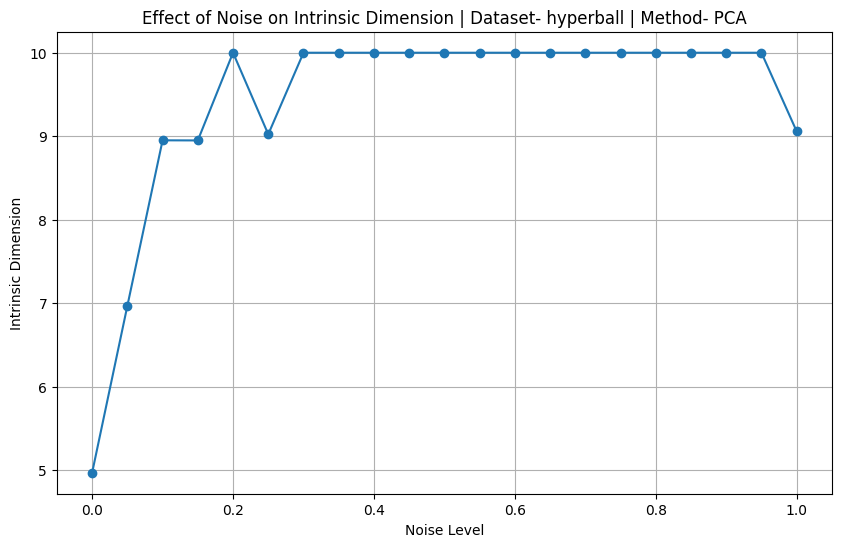

In [32]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(noise_levels, intrinsic_dims, marker='o')
plt.title(f'Effect of Noise on Intrinsic Dimension | Dataset- {dataset} | Method- {method}')
plt.xlabel('Noise Level')
plt.ylabel('Intrinsic Dimension')
plt.grid(True)
plt.show()

In [48]:
# Effect of noise on persistent homology dimension
# Initializing lists to store intrinsic dimensions
intrinsic_dims = []

# Generating noisy data for each noise level and computing intrinsic dimension
for noise_level in noise_levels:
    noise = np.random.normal(0, noise_level, data.shape)
    data_noisy = data + noise
    id_value = estimate_sequence_dimension(data_noisy)
    intrinsic_dims.append(id_value)

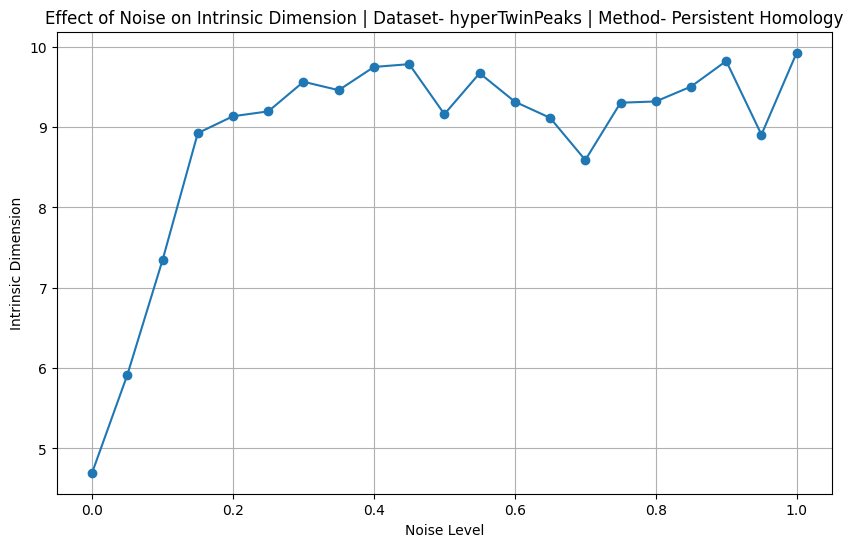

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(noise_levels, intrinsic_dims, marker='o')
plt.title(f'Effect of Noise on Intrinsic Dimension | Dataset- {dataset} | Method- Persistent Homology')
plt.xlabel('Noise Level')
plt.ylabel('Intrinsic Dimension')
plt.grid(True)
plt.show()

## Aggregating Effects of Noise on ID for all Datasets and ID estimators

In [3]:
datasets = {
    "hyperBall": np.zeros((500, 10)),
    "SwissRoll": np.zeros((500, 10)),
    "HyperSphere": np.zeros((500, 10)),
    "hyperTwinPeaks": np.zeros((500, 10))
}

# Generating the data for each dataset
datasets["hyperBall"][:, :5] = skdim.datasets.hyperBall(n=500, d=5, radius=1, random_state=0)
datasets["SwissRoll"][:, :4] = skdim.datasets.swissRoll3Sph(n_swiss=250, n_sphere=250, random_state=0)
datasets["HyperSphere"][:, :6] = skdim.datasets.hyperSphere(n=500, d=5, random_state=0)
datasets["hyperTwinPeaks"][:, :6] = skdim.datasets.hyperTwinPeaks(n=500, d=5, random_state=0)

In [4]:
methods = {
    "TwoNN": skdim.id.TwoNN(),
    # "KNN": skdim.id.KNN(),
    "Maximum Likelihood": skdim.id.MLE(),
    "Fisher Separability": skdim.id.FisherS(),
    "Correlation Dimension": skdim.id.CorrInt(),
    "Tight Local ID": skdim.id.TLE(),
    "PCA": skdim.id.lPCA(ver="Fan"),
    "DANCo": skdim.id.DANCo(k=8),
    "Persistent Homology": lambda embeddings: estimate_sequence_dimension(embeddings),
}

In [5]:
# Defining the range and steps of noise
noise_levels = np.arange(0, 1.05, 0.05)

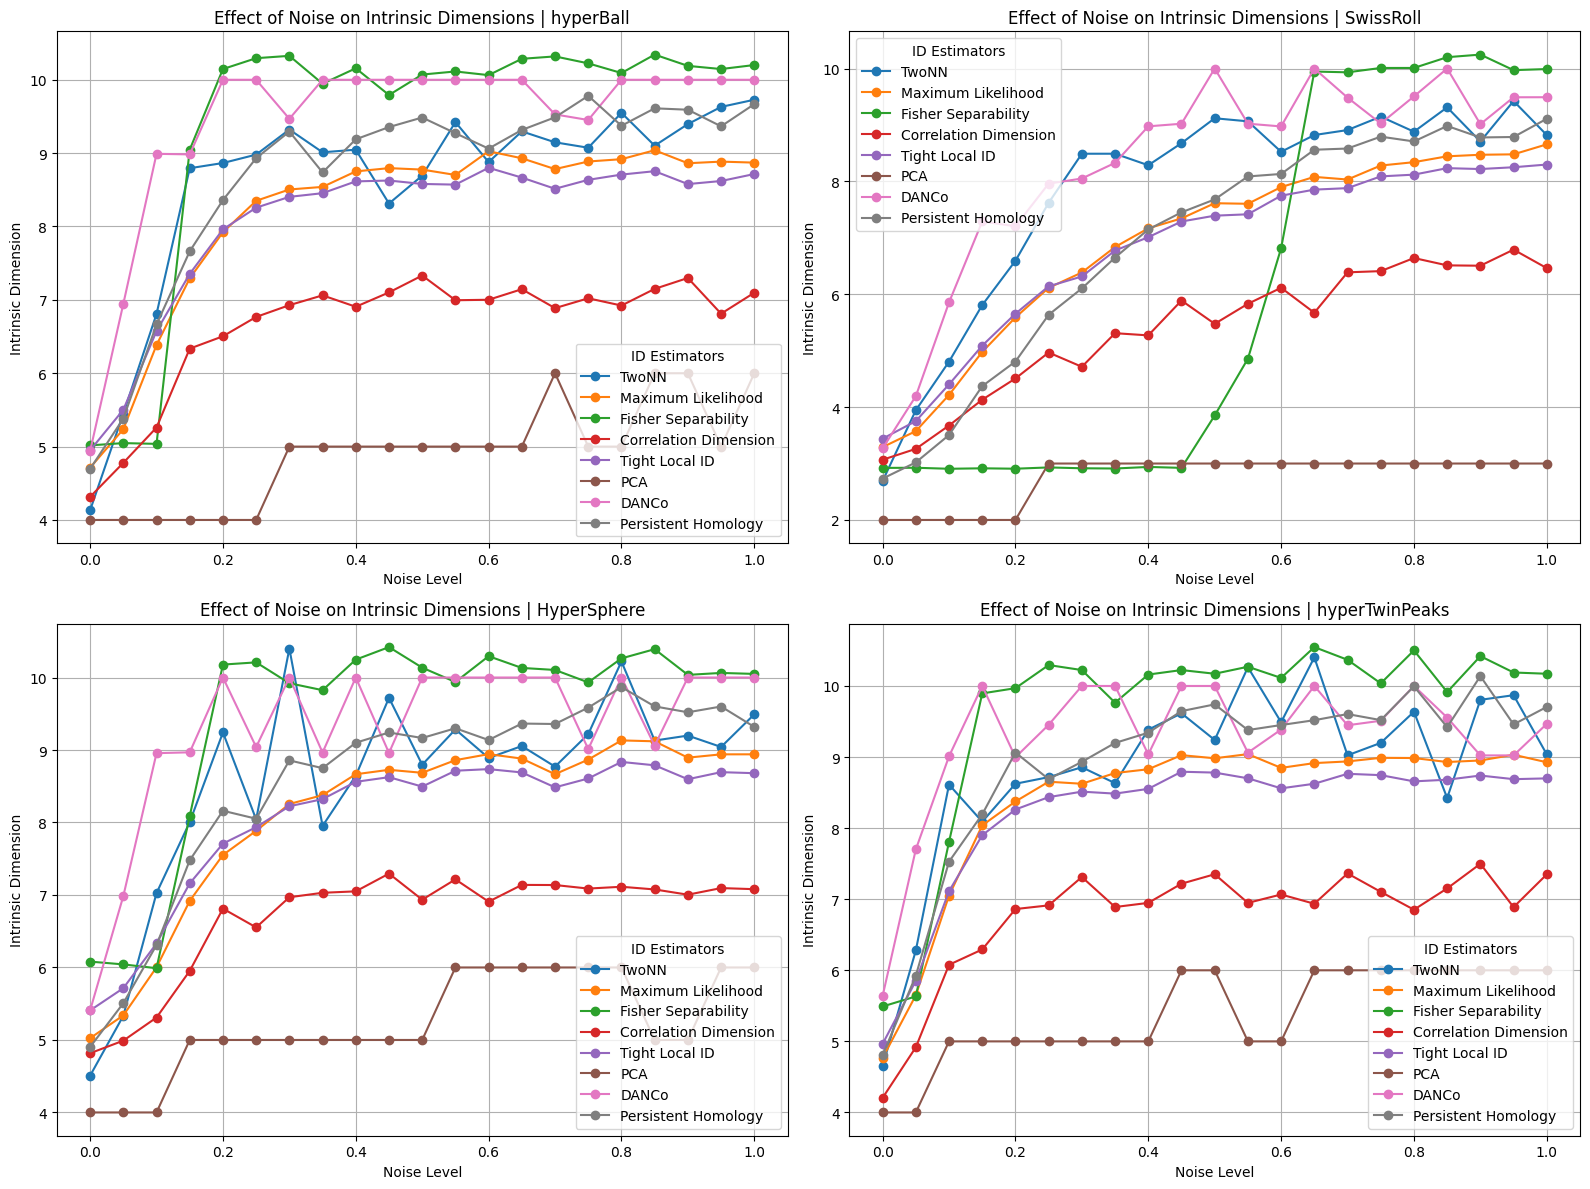

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # 2x2 grid for 4 datasets
axes = axes.flatten()

# Looping over datasets and computing intrinsic dimensions for each
for ax, (dataset_name, data) in zip(axes, datasets.items()):

    intrinsic_dims = {method: [] for method in methods}

    # Generating noisy data and computing intrinsic dimensions
    for noise_level in noise_levels:
        noise = np.random.normal(0, noise_level, data.shape)
        data_noisy = data + noise

        for name, ide in methods.items():
          if name == "Persistent Homology":
            id_value = ide(data_noisy)
          else:
            id_value = ide.fit_transform(data_noisy)
          intrinsic_dims[name].append(id_value)

    # Ploting results for the current dataset
    for name, id_values in intrinsic_dims.items():
        ax.plot(noise_levels, id_values, label=name, marker='o')

    ax.set_xlabel('Noise Level')
    ax.set_ylabel('Intrinsic Dimension')
    ax.set_title(f'Effect of Noise on Intrinsic Dimensions | {dataset_name}')
    ax.legend(title="ID Estimators")
    ax.grid(True)

plt.tight_layout()
plt.show()

### PCA Estimator Experiments

In [20]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples = 500, noise=0.05, random_state=0)

In [40]:
method = "PCA"
versions = ["FO","Fan","maxgap","ratio","participation_ratio","Kaiser","broken_stick"]

In [41]:
# Initializing lists to store intrinsic dimensions
intrinsic_dims = {version:[] for version in versions}

for version in versions:
  ide = skdim.id.lPCA(ver=version)

  # Generating noisy data for each noise level and computing intrinsic dimension
  for noise_level in noise_levels:
      noise = np.random.normal(0, noise_level, X.shape)
      data_noisy = X + noise
      id_value = ide.fit_transform(data_noisy)
      intrinsic_dims[version].append(id_value)

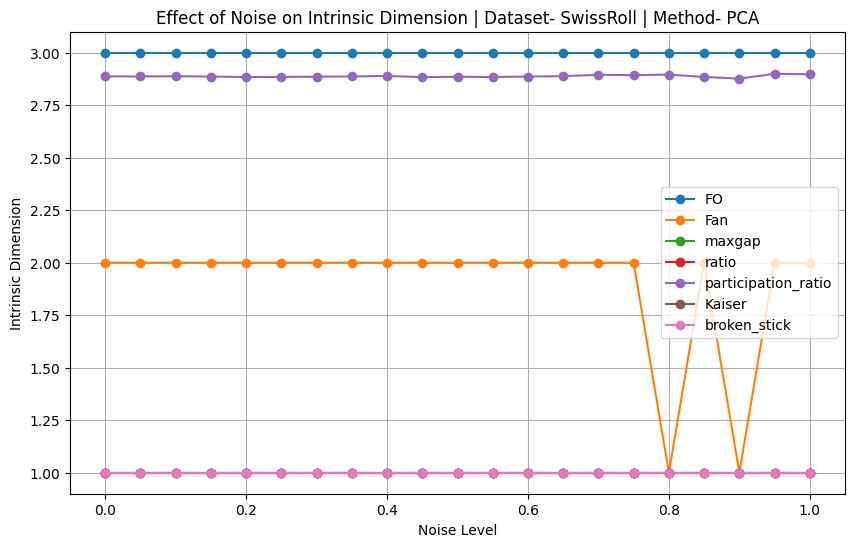

In [42]:
# Plot the results
plt.figure(figsize=(10, 6))
for name, id_values in intrinsic_dims.items():
    plt.plot(noise_levels, id_values, label=name, marker='o')
plt.title(f'Effect of Noise on Intrinsic Dimension | Dataset- {dataset} | Method- {method}')
plt.xlabel('Noise Level')
plt.ylabel('Intrinsic Dimension')
plt.legend()
plt.grid(True)
plt.show()

## Effects of Number of Samples on ID

In [48]:
def generate_dataset(name, n_samples):
  data = np.zeros((n_samples,10))
  if name == "hyperBall":
    data[:,:5] = skdim.datasets.hyperBall(n = n_samples, d = 5, radius = 1, random_state = 0)
    return data
  elif name == "SwissRoll":
    data[:,:4] = skdim.datasets.swissRoll3Sph(n_swiss = n_samples, n_sphere=0, random_state=0)
    return data
  elif name == "HyperSphere":
    data[:,:6] = skdim.datasets.hyperSphere(n = n_samples, d=5, random_state=0)
    return data
  elif name == "hyperTwinPeaks":
    data[:,:6] = skdim.datasets.hyperTwinPeaks(n = n_samples, d=5, random_state=0)
    return data

In [49]:
methods = {
    "TwoNN": skdim.id.TwoNN(),
    # "KNN": skdim.id.KNN(),
    "Maximum Likelihood": skdim.id.MLE(),
    "Fisher Separability": skdim.id.FisherS(),
    "Correlation Dimension": skdim.id.CorrInt(),
    "Tight Local ID": skdim.id.TLE(),
    "PCA": skdim.id.lPCA(ver="Fan"),
    "DANCo": skdim.id.DANCo(k=8),
    "Persistent Homology": lambda embeddings: estimate_sequence_dimension(embeddings),
}

In [50]:
# Defining the range and steps of noise
noise_levels = np.arange(0, 1.05, 0.05)

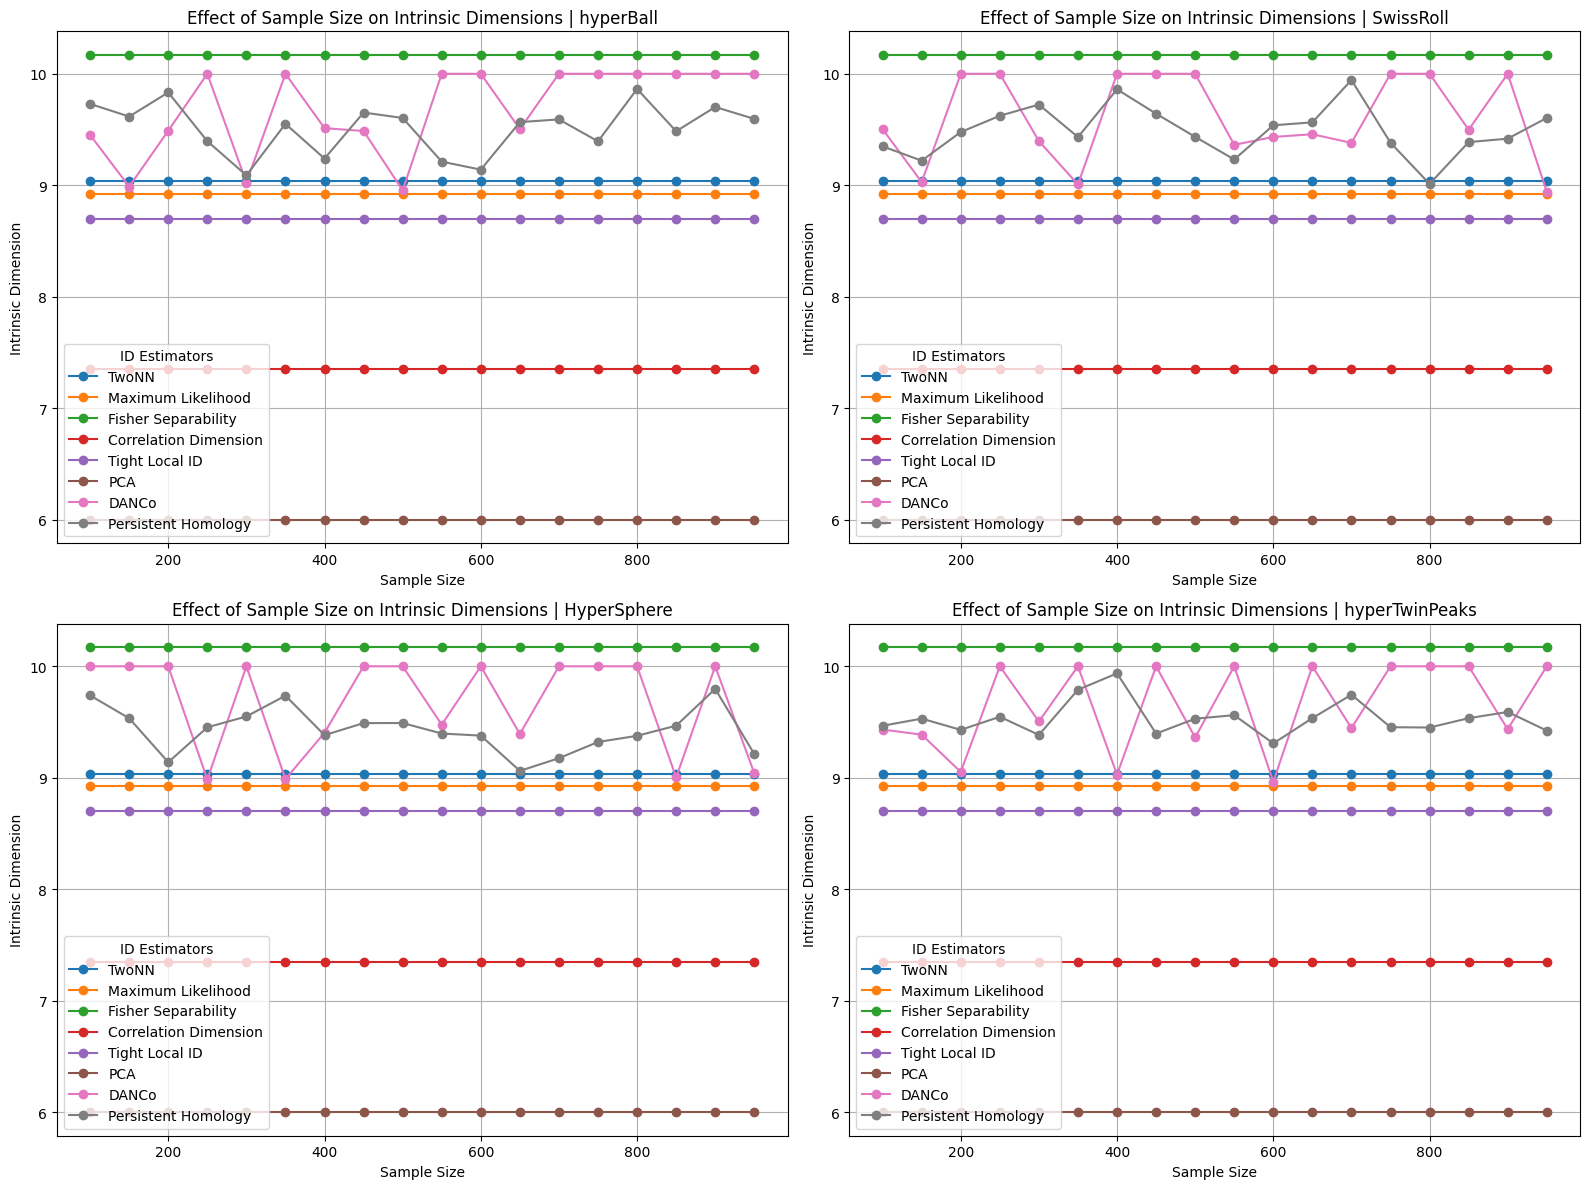

In [52]:
datasets = ["hyperBall", "SwissRoll", "HyperSphere", "hyperTwinPeaks"]
samples = np.arange(100,1000,50)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # 2x2 grid for 4 datasets
axes = axes.flatten()

# Looping over datasets and computing intrinsic dimensions for each
for ax, dataset in zip(axes, datasets):

    intrinsic_dims = {method: [] for method in methods}

    # Generating sample datasets and computing intrinsic dimensions
    for sample in samples:
      data = generate_dataset(dataset, sample)

      for name, ide in methods.items():
        if name == "Persistent Homology":
          id_value = ide(data_noisy)
        else:
          id_value = ide.fit_transform(data_noisy)
        intrinsic_dims[name].append(id_value)

    # Ploting results for the current dataset
    for name, id_values in intrinsic_dims.items():
        ax.plot(samples, id_values, label=name, marker='o')

        ax.set_xlabel('Sample Size')
        ax.set_ylabel('Intrinsic Dimension')
        ax.set_title(f'Effect of Sample Size on Intrinsic Dimensions | {dataset}')
        ax.legend(title="ID Estimators")
        ax.grid(True)

plt.tight_layout()
plt.show()

In [43]:
# Experiments with higher dimension
def generate_dataset(name, n_samples):
  data = np.zeros((n_samples,100))
  if name == "hyperBall":
    data[:,:5] = skdim.datasets.hyperBall(n = n_samples, d = 5, radius = 1, random_state = 0)
    return data

In [44]:
methods = {
    "Maximum Likelihood": skdim.id.MLE(),
    "Correlation Dimension": skdim.id.CorrInt(),
    "Tight Local ID": skdim.id.TLE(),
    "Persistent Homology": lambda embeddings: estimate_sequence_dimension(embeddings),
}

In [45]:
# Defining the range and steps of noise
noise_levels = np.arange(0, 1.05, 0.05)

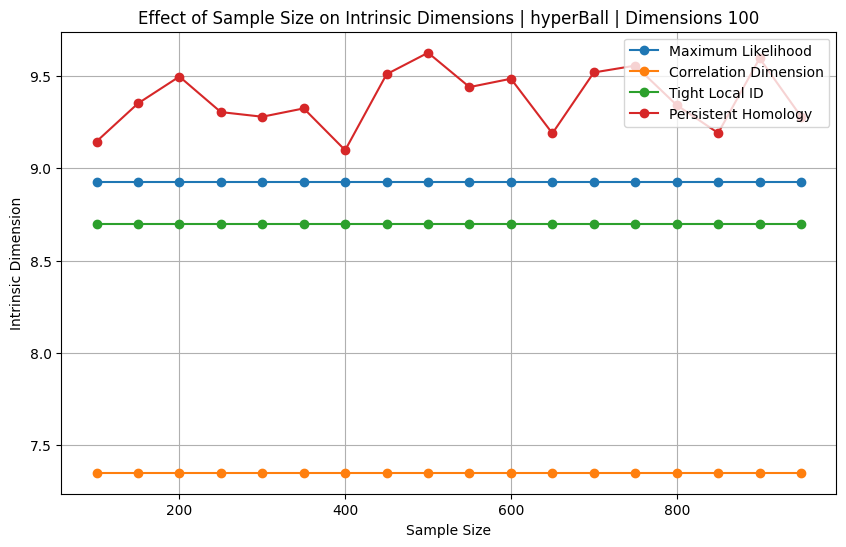

In [47]:
dataset = "hyperBall"
samples = np.arange(100,1000,50)

intrinsic_dims = {method: [] for method in methods}

# Generating sample datasets and computing intrinsic dimensions
for sample in samples:
  data = generate_dataset(dataset, sample)

  for name, ide in methods.items():
    if name == "Persistent Homology":
      id_value = ide(data_noisy)
    else:
      id_value = ide.fit_transform(data_noisy)
    intrinsic_dims[name].append(id_value)

# Plot the results
plt.figure(figsize=(10, 6))
for name, id_values in intrinsic_dims.items():
    plt.plot(samples, id_values, label=name, marker='o')
plt.title(f'Effect of Sample Size on Intrinsic Dimensions | {dataset} | Dimensions 100')
plt.xlabel('Sample Size')
plt.ylabel('Intrinsic Dimension')
plt.legend()
plt.grid(True)
plt.show()